# Grocery Stores Sales Study (from 2023 to 2025)


## Outline

This notebook analyzes a 2023-2025 ***grocery store sales*** dataset with ~1,900 records, containing information on *customer purchases*, *store* and *aisle* details, *products*, *quantities*, *prices*, *discounts*, *final amounts*, *loyalty points*, and *transaction dates*.

Purpose:
The notebook aims to turn raw sales data into actionable insights and an optimized dataset. It focuses on:
* Identifying the most loyal customers per store and understanding purchasing behavior.

* Finding best-selling products each month and high-traffic aisles to improve store layout and inventory planning.

* Cleaning the data to ensure quality and consistency.

* Converting the dataset into a Delta Lake table with partitions and constraints for faster queries, reliable analytics, and scalable data management.




## Prerequisite

### System setup

In [ ]:
%%capture
!pip install pyspark==3.5.3
!pip install -q delta-spark==3.2.1
!pip install pyngrok

In [ ]:
!pip list|grep spark

dataproc-spark-connect                   1.0.1
delta-spark                              3.2.1
pyspark                                  3.5.3


In [ ]:
from pyspark import SparkConf
# from pyspark.context import SparkContext
from pyspark.sql import SparkSession

local = "local[*]"
appName = "Grocery Stores Analysis project with Delta Lake"
localConfig = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "8G").\
  set("spark.driver.memory","8G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension").\
  set("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog").\
  set("spark.jars.packages","io.delta:delta-spark_2.12:3.1.0").\
  set("spark.databricks.delta.schema.autoMerge.enabled","true")

spark = SparkSession.builder.config(conf = localConfig).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [ ]:
spark

### Data import

In this step, we will load the transactional dataset into a Spark DataFrame.
The dataset contains information about customer purchases including:
- customer_id, store_name, transaction_date, aisle, product_name, quantity, unit_price
- total_amount, discount_amount, final_amount, loyalty_points

In [ ]:
! head /content/used_data/grocery_chain_data.csv

customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
2824,GreenGrocer Plaza,2023-08-26,Produce,Pasta,2,7.46,14.92,0.0,14.92,377
5506,ValuePlus Market,2024-02-13,Dairy,Cheese,1,1.85,1.85,3.41,-1.56,111
4657,ValuePlus Market,2023-11-23,Bakery,Onions,4,7.38,29.52,4.04,25.48,301
2679,SuperSave Central,2025-01-13,Snacks & Candy,Cereal,3,5.5,16.5,1.37,15.13,490
9935,GreenGrocer Plaza,2023-10-13,Canned Goods,Orange Juice,5,8.66,43.3,1.5,41.8,22
7912,Corner Grocery,2023-08-31,Dairy,Onions,3,25.04,75.12,1.77,73.35,316
1488,GreenGrocer Plaza,2023-10-18,Produce,Ground Beef,3,29.56,88.68,2.52,86.16,437
4582,City Fresh Store,2024-02-03,Health & Wellness,Orange Juice,2,11.73,23.46,0.0,23.46,107
9279,GreenGrocer Plaza,2024-11-16,Household Items,Apples,5,22.13,110.65,11.07,99.58,83


In [ ]:
query = """
CREATE TABLE IF NOT EXISTS grocery_chain
USING csv
OPTIONS (
  header "true",
  path "/content/used_data/grocery_chain_data.csv",
  inferSchema "true"
)
"""
spark.sql(query)

DataFrame[]

In [ ]:
query = """
DESCRIBE grocery_chain
"""
spark.sql(query).show()

+----------------+---------+-------+
|        col_name|data_type|comment|
+----------------+---------+-------+
|     customer_id|      int|   NULL|
|      store_name|   string|   NULL|
|transaction_date|     date|   NULL|
|           aisle|   string|   NULL|
|    product_name|   string|   NULL|
|        quantity|   double|   NULL|
|      unit_price|   double|   NULL|
|    total_amount|   double|   NULL|
| discount_amount|   double|   NULL|
|    final_amount|   double|   NULL|
|  loyalty_points|      int|   NULL|
+----------------+---------+-------+



In [ ]:
query = """
SELECT * FROM grocery_chain TABLESAMPLE (10 ROWS);
"""
spark.sql(query).show()


+-----------+-----------------+----------------+-----------------+------------+--------+----------+------------+---------------+------------+--------------+
|customer_id|       store_name|transaction_date|            aisle|product_name|quantity|unit_price|total_amount|discount_amount|final_amount|loyalty_points|
+-----------+-----------------+----------------+-----------------+------------+--------+----------+------------+---------------+------------+--------------+
|       2824|GreenGrocer Plaza|      2023-08-26|          Produce|       Pasta|     2.0|      7.46|       14.92|            0.0|       14.92|           377|
|       5506| ValuePlus Market|      2024-02-13|            Dairy|      Cheese|     1.0|      1.85|        1.85|           3.41|       -1.56|           111|
|       4657| ValuePlus Market|      2023-11-23|           Bakery|      Onions|     4.0|      7.38|       29.52|           4.04|       25.48|           301|
|       2679|SuperSave Central|      2025-01-13|   Snacks 

In order to perform a detailed profile report to identify the state of the data, we have to drop the transaction_date column due to compatibility issues with the data profiling library used.

In [ ]:
query = """
SELECT t.*, month(transaction_date) AS month, year(transaction_date) AS year FROM grocery_chain t;
"""
rawdf = spark.sql(query)

Instead, we created two new columns "*month*" and "*year*" in order to keep the time relevant data

In [ ]:
df = rawdf.drop("transaction_date")

df.printSchema()
df.show(5)

root
 |-- customer_id: integer (nullable = true)
 |-- store_name: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- quantity: double (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- final_amount: double (nullable = true)
 |-- loyalty_points: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

+-----------+-----------------+--------------+------------+--------+----------+------------+---------------+------------+--------------+-----+----+
|customer_id|       store_name|         aisle|product_name|quantity|unit_price|total_amount|discount_amount|final_amount|loyalty_points|month|year|
+-----------+-----------------+--------------+------------+--------+----------+------------+---------------+------------+--------------+-----+----+
|       2824|GreenGrocer Plaza|       Produc

Phase 0 : Understanding data

In [ ]:
query = """
select count(*) AS number_of_customers from grocery_chain
"""
spark.sql(query).show()

+-------------------+
|number_of_customers|
+-------------------+
|               1980|
+-------------------+



In [ ]:
query = """
SELECT customer_id, store_name, loyalty_points
FROM grocery_chain
TABLESAMPLE (5 ROWS)
ORDER BY loyalty_points DESC
"""
small = spark.sql(query)


In [ ]:
small.show(5)

+-----------+------------------+--------------+
|customer_id|        store_name|loyalty_points|
+-----------+------------------+--------------+
|       6085| SuperSave Central|           500|
|       4394|  QuickStop Market|           499|
|       6598|    Corner Grocery|           499|
|       6590| GreenGrocer Plaza|           498|
|       4228|FamilyFood Express|           498|
+-----------+------------------+--------------+
only showing top 5 rows



In [ ]:
%%capture
! pip install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport


In [ ]:
grocery_report = ProfileReport(df,
                title='grocery profile',
                interactions=None,
                missing_diagrams=None,
                correlations=None)

In [ ]:
grocery_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Phase 1: Cleaning the data and selecting relevant columns

After understanding the data, we clean it to ensure analysis is accurate.


Cleaning steps include:
- Removing rows with null values in critical columns
- Filling missing values for optional columns or using default values
- Ensuring numerical columns (quantity, unit_price, total_amount, final_amount, loyalty_points) are non-negative
- Removing duplicates if they exist
- Correcting data inconsistencies

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import col
expected_types = {
    "customer_id": IntegerType(),
    "quantity": DoubleType(),
    "unit_price": DoubleType(),
    "total_amount": DoubleType(),
    "discount_amount": DoubleType(),
    "final_amount": DoubleType(),
    "loyalty_points": IntegerType(),
    "month": IntegerType(),
    "year": IntegerType()
}

#listing types of columns

In [ ]:
for c, dtype in expected_types.items():
    df = df.withColumn(c, col(c).cast(dtype))
#enforcing the types to make sure they are respected

In [ ]:
#rules values should respect to be correct
df = df.filter((col("quantity") >= 0) &
               (col("unit_price") >= 0) &
               (col("total_amount") >= 0) &
               (col("discount_amount") >= 0) &
               (col("final_amount") >= 0) &
               (col("loyalty_points") >= 0) &
               (col("month").between(1,12)) & (col("year").isin(2023,2024,2025))
               & col("store_name").isNotNull() & col("product_name").isNotNull() &
    col("aisle").isNotNull())
df.show()

+-----------+------------------+-----------------+------------+--------+----------+------------+---------------+------------+--------------+-----+----+
|customer_id|        store_name|            aisle|product_name|quantity|unit_price|total_amount|discount_amount|final_amount|loyalty_points|month|year|
+-----------+------------------+-----------------+------------+--------+----------+------------+---------------+------------+--------------+-----+----+
|       2824| GreenGrocer Plaza|          Produce|       Pasta|     2.0|      7.46|       14.92|            0.0|       14.92|           377|    8|2023|
|       4657|  ValuePlus Market|           Bakery|      Onions|     4.0|      7.38|       29.52|           4.04|       25.48|           301|   11|2023|
|       2679| SuperSave Central|   Snacks & Candy|      Cereal|     3.0|       5.5|        16.5|           1.37|       15.13|           490|    1|2025|
|       9935| GreenGrocer Plaza|     Canned Goods|Orange Juice|     5.0|      8.66|     

In [ ]:
#remove duplicates
df = df.dropDuplicates()

# Handle missing values
numeric_cols = ["customer_id", "quantity", "unit_price", "total_amount",
                "discount_amount", "final_amount", "loyalty_points", "month", "year"]
string_cols = ["store_name", "aisle", "product_name"]


for col_name in numeric_cols:
    df = df.fillna({col_name: 0})

for col_name in string_cols:
    df = df.fillna({col_name: "unknown"})

In [ ]:
df.show()

+-----------+------------------+-----------------+--------------+--------+----------+------------+---------------+------------+--------------+-----+----+
|customer_id|        store_name|            aisle|  product_name|quantity|unit_price|total_amount|discount_amount|final_amount|loyalty_points|month|year|
+-----------+------------------+-----------------+--------------+--------+----------+------------+---------------+------------+--------------+-----+----+
|       5333|FreshMart Downtown|           Bakery|         Bread|     1.0|     25.92|       25.92|           3.89|       22.03|            36|    4|2025|
|       9742|  ValuePlus Market|          Produce|      Tomatoes|     2.0|     20.94|       41.88|           6.28|        35.6|           161|    5|2024|
|       6876| MegaMart Westside|            Dairy|       Bananas|     3.0|     26.14|       78.42|          15.68|       62.74|           332|    9|2023|
|       9189|FreshMart Downtown|    Personal Care|        Apples|     4.0|  


## Phase 2: Organizing the data

Delta tables allow us to store data in a highly secure and reliable way.


Using Delta, we can improve performance, enforce data quality, and enable advanced features like time travel.

In [ ]:
df_grocery_chain = df.select("customer_id", "quantity", "unit_price", "total_amount",
                "discount_amount", "final_amount", "loyalty_points", "month", "year")
#Here we selected the relevant columns from the our clean DataFrame

In [ ]:
df_grocery_chain.write.format("delta").mode("overwrite").saveAsTable("deltaGrocery")
spark.sql("select * from deltaGrocery").show(10)
#Here we Saved the DataFrame as a Delta table for future use and Previewed the first 10 rows to check the data


+-----------+--------+----------+------------+---------------+------------+--------------+-----+----+
|customer_id|quantity|unit_price|total_amount|discount_amount|final_amount|loyalty_points|month|year|
+-----------+--------+----------+------------+---------------+------------+--------------+-----+----+
|       5333|     1.0|     25.92|       25.92|           3.89|       22.03|            36|    4|2025|
|       9742|     2.0|     20.94|       41.88|           6.28|        35.6|           161|    5|2024|
|       6876|     3.0|     26.14|       78.42|          15.68|       62.74|           332|    9|2023|
|       9189|     4.0|     27.68|      110.72|            0.0|      110.72|           126|   11|2024|
|       6194|     4.0|      6.33|       25.32|           1.29|       24.03|             3|   12|2024|
|       9501|     1.0|      9.55|        9.55|           1.91|        7.64|           265|    7|2025|
|       3308|     2.0|      3.64|        7.28|           2.35|        4.93|       

**Adding constraints to enforce data reliability**

In [ ]:
# Here we added constraints to ensure data quality
# Constraint 1: Amounts and quantities must be positive and discounts valid
spark.sql("""
ALTER TABLE deltaGrocery ADD CONSTRAINT first_rule
CHECK (
  quantity>0  AND  unit_price > 0 AND total_amount >=0 AND discount_amount >=0 AND final_amount >=0 AND discount_amount <= total_amount
  )
""")

DataFrame[]

In [ ]:
# Constraint 2: Loyalty points and date fields should be valid
spark.sql("""
ALTER TABLE deltaGrocery ADD CONSTRAINT second_rule
CHECK (
    loyalty_points >= 0 AND month BETWEEN 1 AND 12 AND year >= 2023
)
""")


DataFrame[]

In [ ]:
#Here we  described the table to see columns and constraints
spark.sql("DESCRIBE TABLE deltaGrocery").show()
# Here we printed the  schema of the DataFrame
spark.table("deltaGrocery").printSchema()

+---------------+---------+-------+
|       col_name|data_type|comment|
+---------------+---------+-------+
|    customer_id|      int|   NULL|
|       quantity|   double|   NULL|
|     unit_price|   double|   NULL|
|   total_amount|   double|   NULL|
|discount_amount|   double|   NULL|
|   final_amount|   double|   NULL|
| loyalty_points|      int|   NULL|
|          month|      int|   NULL|
|           year|      int|   NULL|
+---------------+---------+-------+

root
 |-- customer_id: integer (nullable = true)
 |-- quantity: double (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- final_amount: double (nullable = true)
 |-- loyalty_points: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [ ]:
# Cheking number of rows before inserting the data
spark.table("deltaGrocery").count()


1942

**Inserting Invalid data to check schema on write**

This cell attempts to insert invalid data into the 'deltaGrocerys' table.
The purpose is to verify that Delta constraints reject bad data. Expected behavior: the write should fail, and the table should remain unchanged.

In [ ]:
# Examples of  invalid data
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
invalid_data = [
    (1, -5, 10, 50, 5, 45, 10, 5, 2023),     # quantity negative
    (2, 3, 0, 30, 5, 25, -10, 3, 2023),       # unit_price zero, loyalty_points negative
    (3, 2, 15, 20, 25, -5, 5, 13, 2022),      # discount_amount > total_amount, month invalid, year invalid
]


schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("quantity", DoubleType(), True),
    StructField("unit_price", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("discount_amount", DoubleType(), True),
    StructField("final_amount", DoubleType(), True),
    StructField("loyalty_points", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("year", IntegerType(), True)
])

columns = ["customer_id", "quantity", "unit_price", "total_amount",
           "discount_amount", "final_amount", "loyalty_points", "month", "year"]

df_invalid = spark.createDataFrame(invalid_data, schema=columns)
df_invalid.show()


+-----------+--------+----------+------------+---------------+------------+--------------+-----+----+
|customer_id|quantity|unit_price|total_amount|discount_amount|final_amount|loyalty_points|month|year|
+-----------+--------+----------+------------+---------------+------------+--------------+-----+----+
|          1|      -5|        10|          50|              5|          45|            10|    5|2023|
|          2|       3|         0|          30|              5|          25|           -10|    3|2023|
|          3|       2|        15|          20|             25|          -5|             5|   13|2022|
+-----------+--------+----------+------------+---------------+------------+--------------+-----+----+



In [ ]:
# Attempt to overwrite Delta table with invalid data
try:
    df_invalid.write.format("delta").mode("append").saveAsTable("deltaGrocery")
except Exception as e:
    print("Error while inserting invalid data:", e)


Error while inserting invalid data: Failed to merge fields 'customer_id' and 'customer_id'. Failed to merge incompatible data types IntegerType and LongType


## Phase 3: Analysing the data and ensuring query evaluation effeciency

1 - Identifying most loyal customer of all times for each store

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window_spec = Window.partitionBy("store_name").orderBy(F.desc("loyalty_points"))

df_ranked = df.withColumn("row_num", F.row_number().over(window_spec))

most_loyal_customers = df_ranked.filter(F.col("row_num") == 1) \
    .select(
        F.col("store_name"),
        F.col("loyalty_points").alias("most_loyal_customer_points"),
        F.col("customer_id").alias("most_loyal_customer_id")
    )

most_loyal_customers.show()



+------------------+--------------------------+----------------------+
|        store_name|most_loyal_customer_points|most_loyal_customer_id|
+------------------+--------------------------+----------------------+
|  City Fresh Store|                       498|                  4986|
|    Corner Grocery|                       499|                  6598|
|FamilyFood Express|                       498|                  3329|
|FreshMart Downtown|                       495|                  2887|
| GreenGrocer Plaza|                       498|                  8378|
| MegaMart Westside|                       500|                  1187|
|  QuickStop Market|                       500|                  3362|
| SuperSave Central|                       500|                  6085|
|  ValuePlus Market|                       500|                  6927|
+------------------+--------------------------+----------------------+



/tmp/ipython-input-1941518087.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


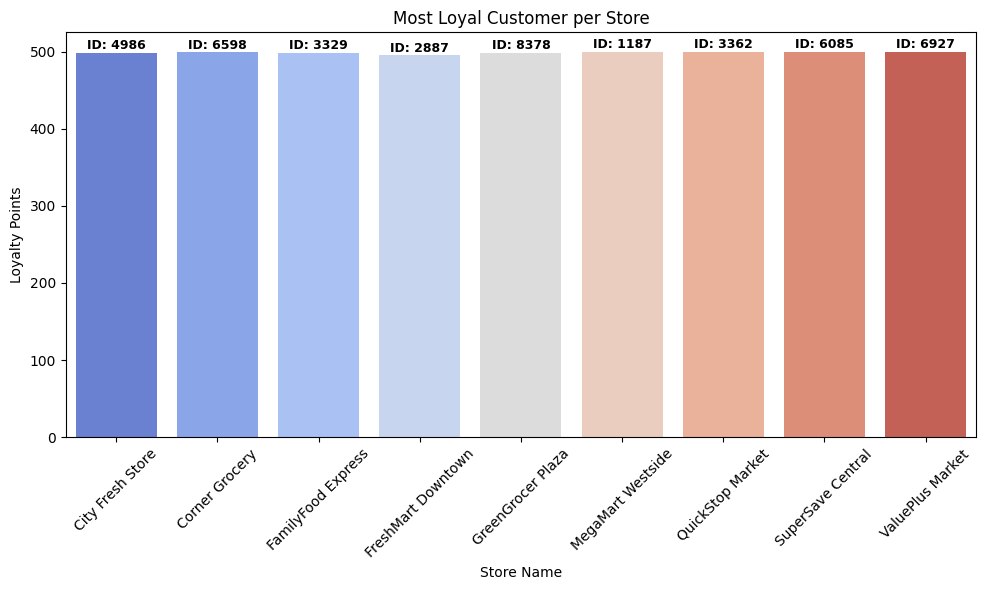

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


df_pd = most_loyal_customers.toPandas()

plt.figure(figsize=(10,6))

bar_plot = sns.barplot(
    x="store_name",
    y="most_loyal_customer_points",
    data=df_pd,
    palette="coolwarm"
)

for index, row in df_pd.iterrows():
    bar_plot.text(
        x=index,
        y=row["most_loyal_customer_points"] + 1,
        s=f'ID: {row["most_loyal_customer_id"]}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.title("Most Loyal Customer per Store")
plt.xlabel("Store Name")
plt.ylabel("Loyalty Points")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



2 - Best selling and performing production monthly for each year (2023, 2024, 2025)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window


df_filtered = df.filter(F.col("year").isin([2023, 2024, 2025]))

monthly_sales = df_filtered.groupBy(
    "year", "month", "product_name"
).agg(
    F.sum("quantity").alias("total_quantity_sold")
)

window_spec = Window.partitionBy("year", "month").orderBy(F.desc("total_quantity_sold"))

ranked_sales = monthly_sales.withColumn("rank", F.row_number().over(window_spec))

best_selling_products = ranked_sales.filter(F.col("rank") == 1) \
    .select(
        "year",
        "month",
        F.col("product_name").alias("best_selling_product"),
        "total_quantity_sold"
    ).orderBy("year", "month")

best_selling_products.show(36)  # show top product for each month of each year


+----+-----+--------------------+-------------------+
|year|month|best_selling_product|total_quantity_sold|
+----+-----+--------------------+-------------------+
|2023|    8|      Chicken Breast|               22.0|
|2023|    9|            Potatoes|               27.0|
|2023|   10|        Orange Juice|               32.0|
|2023|   11|         Ground Beef|               25.0|
|2023|   12|      Chicken Breast|               22.0|
|2024|    1|        Orange Juice|               22.0|
|2024|    2|            Tomatoes|               24.0|
|2024|    3|               Pasta|               32.0|
|2024|    4|              Onions|               21.0|
|2024|    5|               Bread|               27.0|
|2024|    6|                Rice|               29.0|
|2024|    7|      Chicken Breast|               30.0|
|2024|    8|              Cereal|               27.0|
|2024|    9|            Potatoes|               25.0|
|2024|   10|               Bread|               26.0|
|2024|   11|              Ce

In [ ]:
best_selling_products_pd = best_selling_products.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_best_selling_products(year):
    data_year = best_selling_products_pd[best_selling_products_pd['year'] == year]

    data_year = data_year.sort_values('month')

    plt.figure(figsize=(12,5))
    bars = plt.bar(
        x=data_year['month'],
        height=data_year['total_quantity_sold'],
        color='skyblue',
        edgecolor='black'
    )
    for bar, product in zip(bars, data_year['best_selling_product']):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            product,
            ha='center',
            va='bottom',
            fontsize=9,
            rotation=45
        )

    plt.xticks(range(1,13))
    plt.xlabel("Month")
    plt.ylabel("Total Quantity Sold")
    plt.title(f"Best-Selling Products per Month - {year}")
    plt.ylim(0, data_year['total_quantity_sold'].max() * 1.2)  # give space for labels
    plt.show()


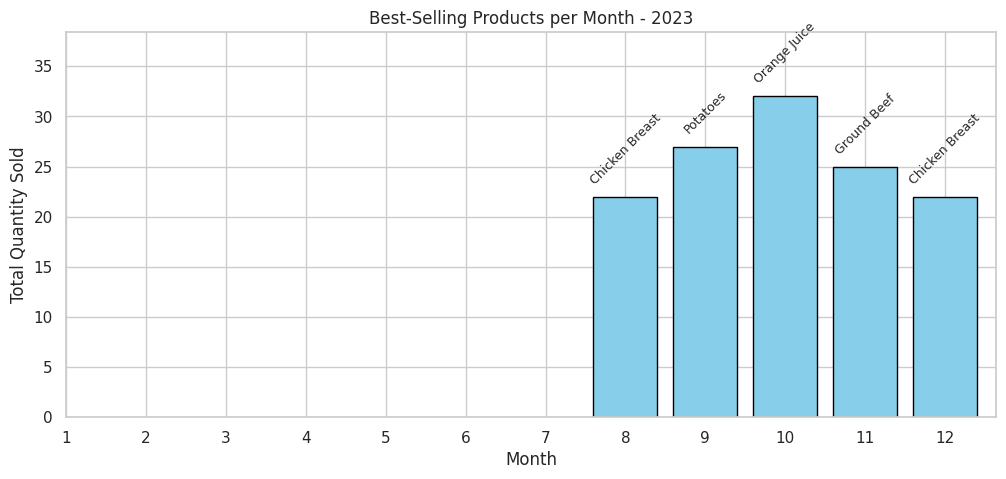

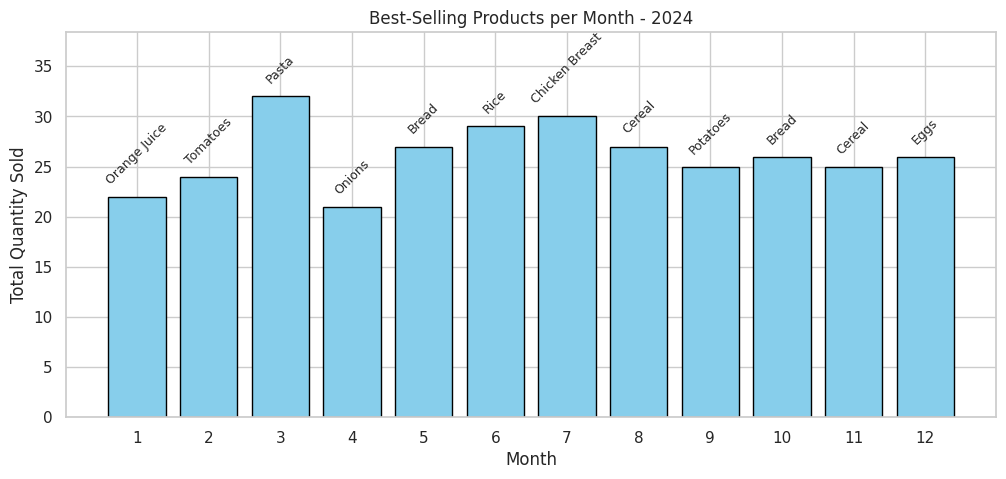

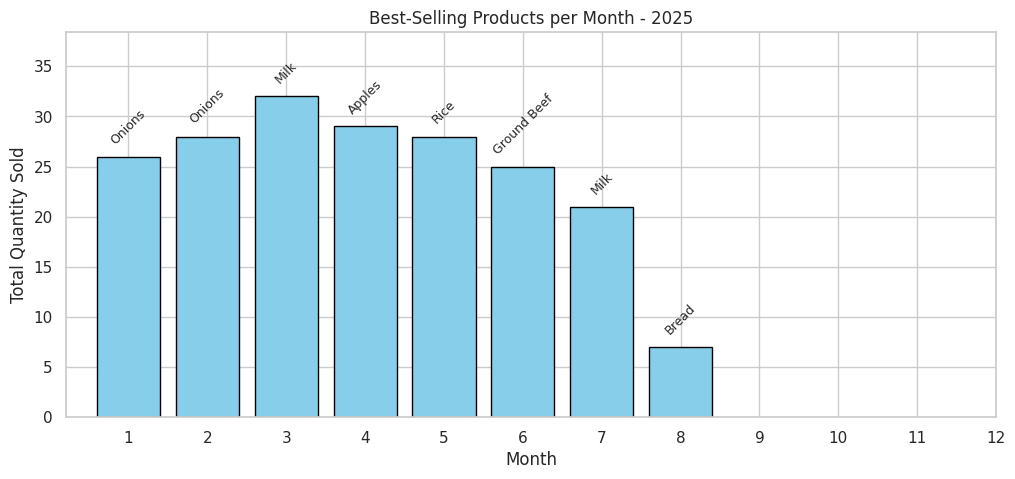

In [ ]:
plot_best_selling_products(2023)
plot_best_selling_products(2024)
plot_best_selling_products(2025)


3 - Identifying most frequently visited aisle for each store in order to improve client service in the right aisle efficiently

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# count visits for each aisle per store
aisle_count = df.groupBy("store_name", "aisle") \
                .agg(F.count("customer_id").alias("visit_count"))
window = Window.partitionBy("store_name").orderBy(F.desc("visit_count"))

# filter only the top aisle per store
top_aisle = aisle_count.withColumn("rank", F.row_number().over(window)) \
                       .filter(F.col("rank") == 1) \
                       .select("store_name", "aisle", "visit_count")

top_aisle.show()

+------------------+---------------+-----------+
|        store_name|          aisle|visit_count|
+------------------+---------------+-----------+
|  City Fresh Store|  Personal Care|         27|
|    Corner Grocery|  Personal Care|         32|
|FamilyFood Express|Household Items|         26|
|FreshMart Downtown|Household Items|         23|
| GreenGrocer Plaza|          Dairy|         24|
| MegaMart Westside| Meat & Seafood|         26|
|  QuickStop Market|      Beverages|         24|
| SuperSave Central|   Canned Goods|         32|
|  ValuePlus Market| Snacks & Candy|         28|
+------------------+---------------+-----------+



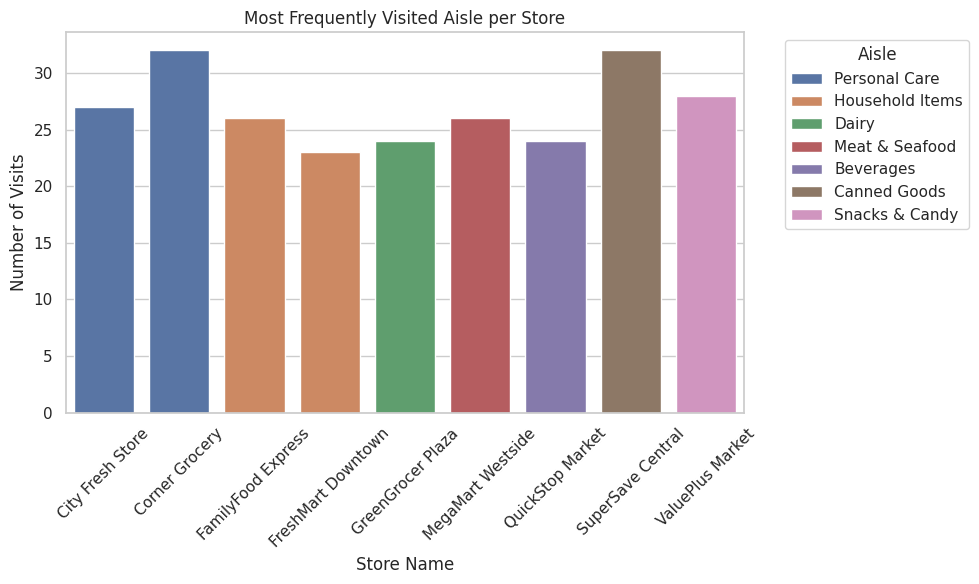

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_aisle_pd = top_aisle.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=top_aisle_pd, x="store_name", y="visit_count", hue="aisle", dodge=False)
plt.title("Most Frequently Visited Aisle per Store")
plt.xticks(rotation=45)
plt.ylabel("Number of Visits")
plt.xlabel("Store Name")
plt.legend(title="Aisle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Ingesting new data and showcasing history records

In [ ]:
spark.sql("DESCRIBE HISTORY deltaGrocery").show()


+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      2|2026-01-16 08:29:...|  NULL|    NULL|      ADD CONSTRAINT|{name -> second_r...|NULL|    NULL|     NULL|          1|  Serializable|        false|                  {}|        NULL|Apache-Spark/3.5....|
|      1|2026-01-16 08:28:...|  NULL|    NULL|      ADD CONSTRAINT|{name -> first_ru...|NULL|    NULL|     NULL|          0|  Serializable|        false|           

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

# Adding new rows
new_data = [
    (1001, "SuperShop", "Dairy", "Milk", 2.0, 12.0, 24.0, 4.0, 20.0, 15, 2, 2023),
    (1002, "SuperShop", "Bakery", "Bread", 3.0, 8.0, 24.0, 2.0, 22.0, 12, 3, 2023)
]

# Define schema
schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("store_name", StringType(), True),
    StructField("aisle", StringType(), True),
    StructField("product_name", StringType(), True),
    StructField("quantity", DoubleType(), True),
    StructField("unit_price", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("discount_amount", DoubleType(), True),
    StructField("final_amount", DoubleType(), True),
    StructField("loyalty_points", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("year", IntegerType(), True)
])

df_new = spark.createDataFrame(new_data, schema=schema)

# Append to existing Delta table → creates a new version
df_new.write.format("delta").mode("append").saveAsTable("deltaGrocery")


In [ ]:
spark.sql("DESCRIBE HISTORY deltaGrocery").show()


+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      4|2026-01-16 08:45:...|  NULL|    NULL|               WRITE|{mode -> Append, ...|NULL|    NULL|     NULL|          3|  Serializable|         true|{numFiles -> 2, n...|        NULL|Apache-Spark/3.5....|
|      3|2026-01-16 08:29:...|  NULL|    NULL|               WRITE|{mode -> Append, ...|NULL|    NULL|     NULL|          2|  Serializable|         true|{numFiles -

In [ ]:
query = """
SELECT year, SUM(final_amount) AS total_revenue
FROM deltaGrocery VERSION AS OF 1
GROUP BY year;
"""

spark.sql(query).show()


+----+------------------+
|year|     total_revenue|
+----+------------------+
|2025| 24210.12000000001|
|2023|16248.939999999999|
|2024|40437.710000000014|
+----+------------------+



In [ ]:
query = """
SELECT
    old.year,
    old.total_revenue AS revenue_before,
    new.total_revenue AS revenue_after,
    (new.total_revenue - old.total_revenue) AS revenue_growth
FROM
    (SELECT year, SUM(final_amount) AS total_revenue
     FROM deltaGrocery VERSION AS OF 1
     GROUP BY year) old
JOIN
    (SELECT year, SUM(final_amount) AS total_revenue
     FROM deltaGrocery VERSION AS OF 3
     GROUP BY year) new
ON old.year = new.year;
"""

spark.sql(query).show()

+----+------------------+------------------+--------------+
|year|    revenue_before|     revenue_after|revenue_growth|
+----+------------------+------------------+--------------+
|2025| 24210.12000000001| 24210.12000000001|           0.0|
|2023|16248.939999999999|16290.939999999999|          42.0|
|2024|40437.710000000014|40437.710000000014|           0.0|
+----+------------------+------------------+--------------+



# Data Layout Optimazation : Partitioning Strategy

The dataset contains transactional grocery data with the following key attributes:
- Customer ID
- Product details
- Monetary values
- Temporal attributes (month, year)

***Time-based*** queries are **frequent**, making this schema suitable for layout optimization.

1 - Applying the Partitioning Strategy

In [ ]:
query1 = """
CREATE OR REPLACE TABLE deltaGrocery_partitioned
USING DELTA
PARTITIONED BY (year, month)
AS
SELECT *
FROM deltaGrocery
"""
spark.sql(query1)
# rewriting the table and organizing data into directory partitions.

DataFrame[]

2 - Evaluating the data layout optimization

In [ ]:
query_before = """SELECT SUM(final_amount)
FROM deltaGrocery
WHERE year = 2023 AND month = 4;"""

spark.sql(query_before).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[], functions=[sum(final_amount#23828)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=13311]
      +- HashAggregate(keys=[], functions=[partial_sum(final_amount#23828)])
         +- Project [final_amount#23828]
            +- Filter (((isnotnull(year#23831) AND isnotnull(month#23830)) AND (year#23831 = 2023)) AND (month#23830 = 4))
               +- FileScan parquet spark_catalog.default.deltagrocery[final_amount#23828,month#23830,year#23831] Batched: true, DataFilters: [isnotnull(year#23831), isnotnull(month#23830), (year#23831 = 2023), (month#23830 = 4)], Format: Parquet, Location: PreparedDeltaFileIndex(1 paths)[file:/content/spark-warehouse/deltagrocery], PartitionFilters: [], PushedFilters: [IsNotNull(year), IsNotNull(month), EqualTo(year,2023), EqualTo(month,4)], ReadSchema: struct<final_amount:double,month:int,year:int>




In the **non-partitioned** deltagrocery table, we scan all files with a FileScan, apply the year and month Filter, select final_amount with Project, compute partial sums using *HashAggregate*, combine them into one partition using *exchange*, and then calculate the final sum.
**Scanning all rows makes it less efficient.**

In [ ]:
query_after = """SELECT SUM(final_amount)
FROM deltaGrocery_partitioned
WHERE year = 2023 AND month = 4"""

spark.sql(query_after).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[], functions=[sum(final_amount#24006)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=13358]
      +- HashAggregate(keys=[], functions=[partial_sum(final_amount#24006)])
         +- Project [final_amount#24006]
            +- FileScan parquet spark_catalog.default.deltagrocery_partitioned[final_amount#24006,year#24009,month#24008] Batched: true, DataFilters: [], Format: Parquet, Location: PreparedDeltaFileIndex(1 paths)[file:/content/spark-warehouse/deltagrocery_partitioned], PartitionFilters: [isnotnull(year#24009), isnotnull(month#24008), (year#24009 = 2023), (month#24008 = 4)], PushedFilters: [], ReadSchema: struct<final_amount:double>




In the **partitioned** table, we only read only the relevant partitions for year 2023 and month 4, and skip irrelevant files. The *Project*, *HashAggregate*, *Exchange*, and *final HashAggregate* work the same as in the non-partitioned plan.
**By scanning only needed partitions, we speed up the query.**

We will compare time of execution, for example to get data from year 2023 and month 4, for the data before and after the partitioning in order to prove the efficiency of the optimization

In [ ]:
import time
df1 = spark.table("deltagrocery").filter("year = 2023 AND month = 4")

df2 = spark.table("deltagrocery_partitioned").filter("year = 2023 AND month = 4")

start = time.time()
df1.selectExpr("sum(final_amount)").collect()
print("Non-partitioned data execution time:", time.time() - start)

start = time.time()
df2.selectExpr("sum(final_amount)").collect()
print("Partitioned data execution time:", time.time() - start)


Non-partitioned data execution time: 1.7969682216644287
Partitioned data execution time: 1.2228507995605469
